<a href="https://colab.research.google.com/github/david2003-bite-10-23/generative_ai/blob/main/final_project_chess_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 使用的模型:gpt-3.5-turbo(使用自openAI的API)
### 動機以及目的:最近在學西洋棋發現到開局是西洋棋棋局中基本中的基本，因此決定使用stockfish(西洋棋引擎)和llm作一個結合，希望開發出幫助新手學習西洋棋開局的專案

### 實作說明:先架設好stockfish讓他提供當前棋局的最好3步，然後我將當前棋局的局面以及由stockfish提供出的三個較好的選擇一起提供給llm的API，請他就這三個選擇進行說明以及加上一些有趣的典故以及鼓勵，以此來讓我學習的過程不無聊，與西洋棋相關的規則以及棋局和棋子的圖片都已經有人寫好相關的模組，因此直接選擇飲用節省開發時間以及實作困難度





### 使用說明以及最終成果展示
最一開始都是空的，要先按下"新局:您是黑棋"或者是"新局:您是白棋"才會開始
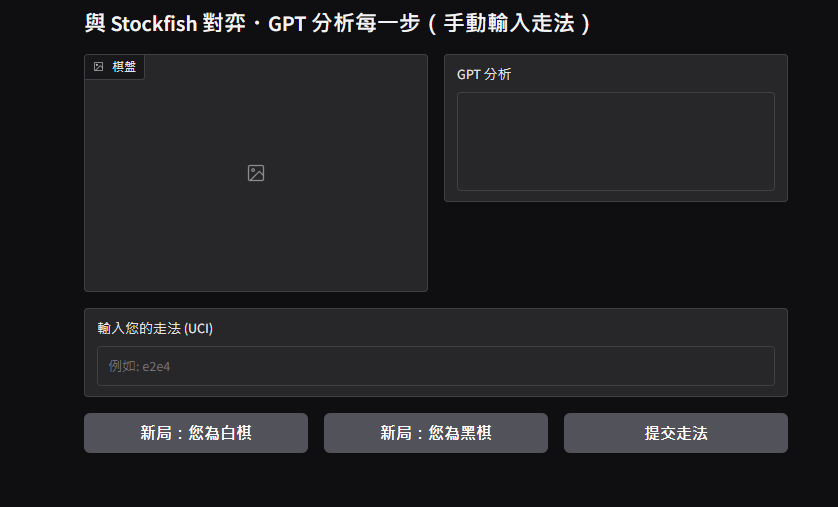
這是您是白棋的時候的初始頁面
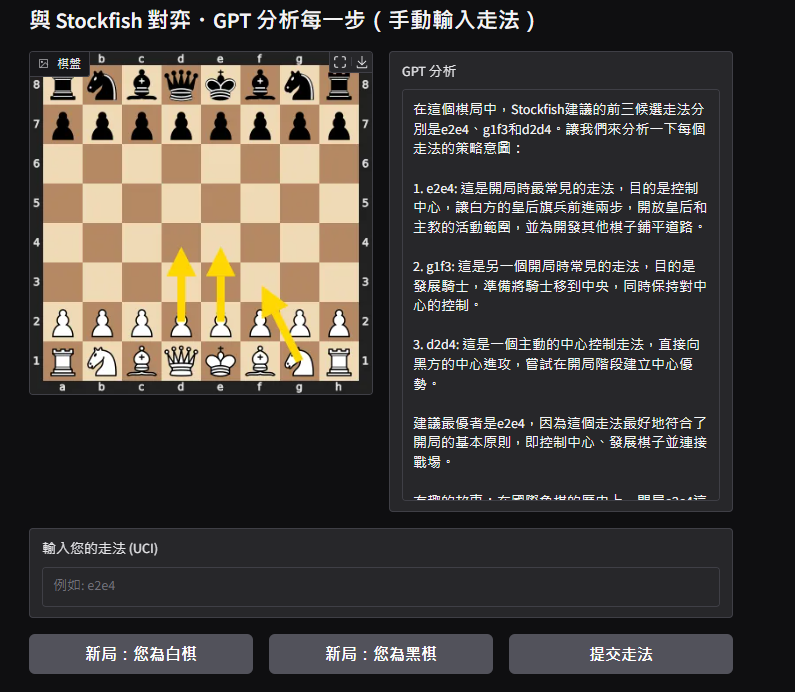
這是您是黑棋的時候的初始頁面
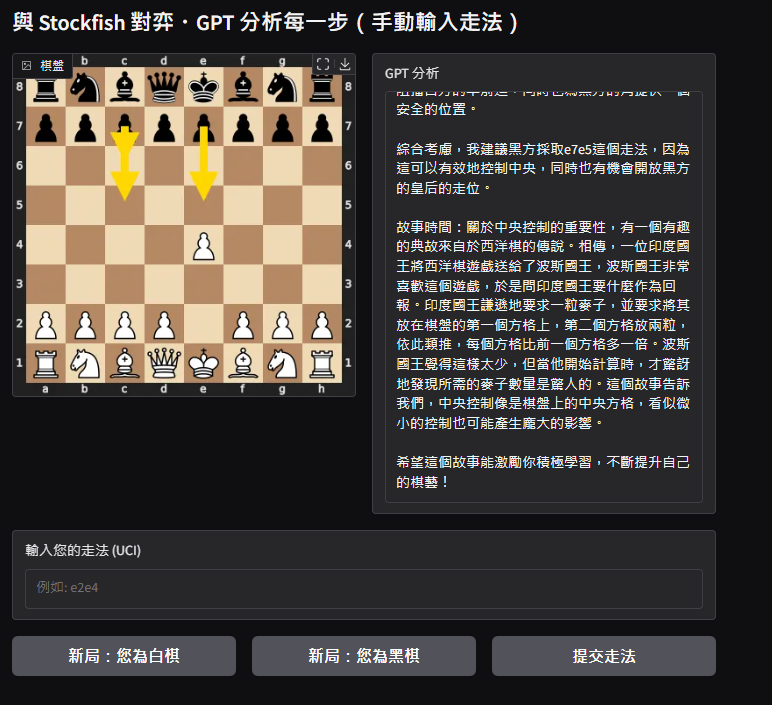

###開始棋局之後的截圖以及使用指引
正確的使用方式是對於接下來要下的棋步請輸入起始的格子以及目的地格子的座標(x軸是a到g，y軸是1到8)，比如說我現在想要讓白色的兵從e2這一個格子移動到e4這一個格子，那我就會輸入e2e4，並按下提交走法，他就會開始運行並生成回復，這一個過程大約10秒，如果輸入的是非法的走法就會請你重新提交(第一張圖是提交走法的範例，第二張圖是提交走法成功的範例，第三張圖是提交走法失敗的範例)
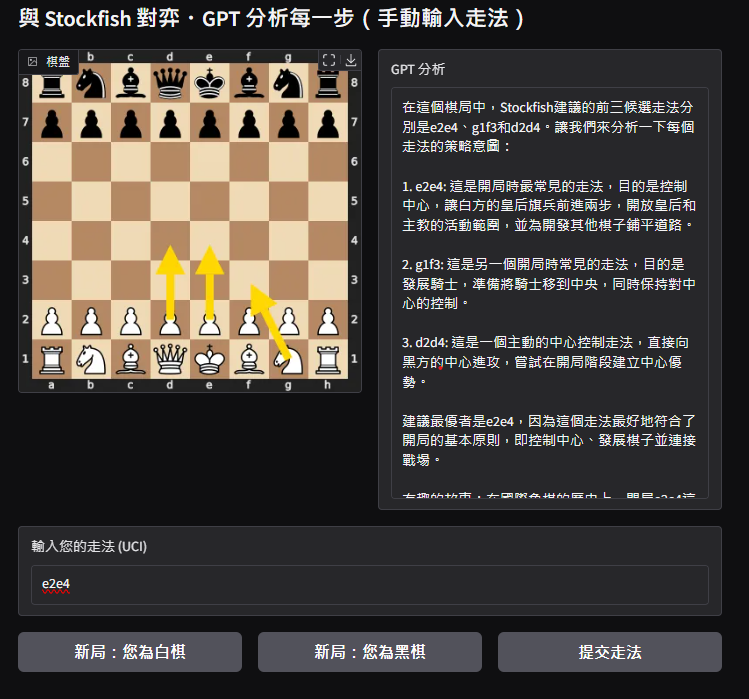
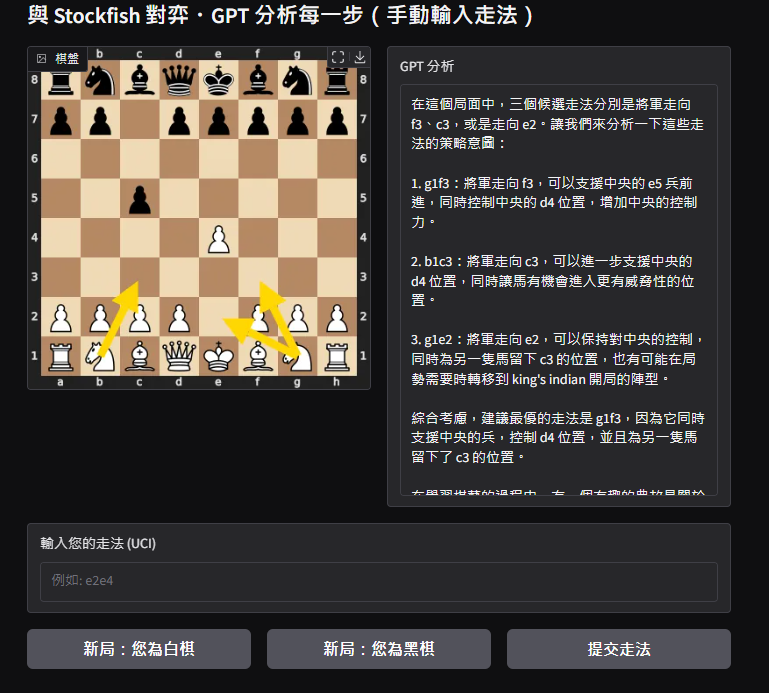
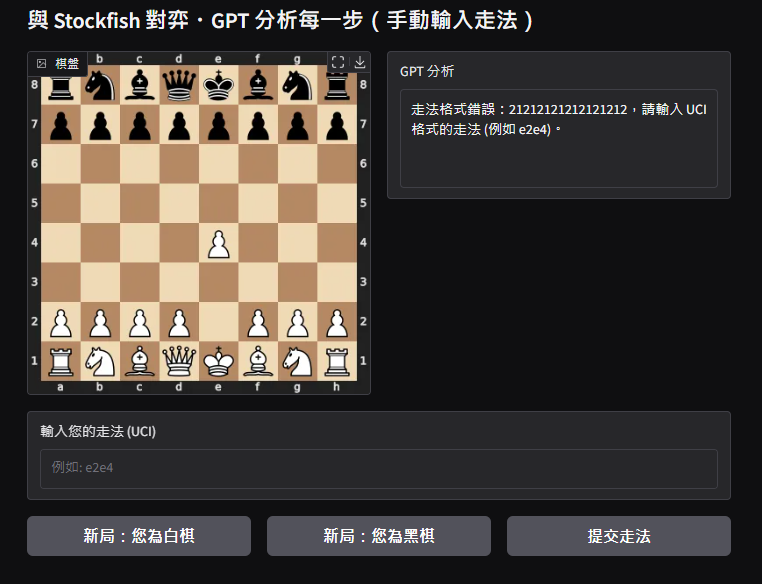

如果其中一方勝利就會在gpt分析的格子中顯示終局，這時候請重新按下您是黑棋"或者是"新局:您是白棋"重新開始

### P.S.
###1.此專案適用於已經知道西洋棋基本規則的人，因此不會提供基本導引，如果在下棋的時候對規則有所不理解時建議可以詢問gpt(但是每一次使用者要下棋之前會用箭頭提醒最好的三步驟，如果不是很會下建議可以跟著箭頭下)
###2.stockfish的引擎非常強大所以輸掉是正常的
###3.這一個專案主要是在對開局做教學，進入到殘局的時候再使用他的意義就不大了，逐步分析只會浪費時間，這是這一個專案的缺點
###4.為了反應速度我特意選用gpt-3.5-turbo的模型來使用，這樣一個來回大概在10秒以內，如果你有興趣使用更好的引擎也可以嘗試看看gpt-4的回覆時間大概是30秒左右，但就回復的質量來看的話我覺得他也並沒有比gpt-3.5-turbo好的特別多，我認為gpt-3.5-turbo的回覆質量就已經很不錯了
###5.為避免您完全不理解規則這裡提供簡單的說明:https://chatgpt.com/share/682c1120-c918-8010-8fdb-0c8ee03fe430
###，他還少提到一個就是在開始遊戲時一定都是白棋先走



In [1]:
# 更新套件列表，並安裝 Stockfish
!apt-get -qq update && apt-get -qq install -y stockfish

# 安裝 Python 套件：python-chess、CairoSVG（SVG→PNG）、Pillow、Gradio、OpenAI
!pip install -q python-chess cairosvg pillow gradio openai


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package stockfish.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 68.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.9 MB/s eta 0:00:00
   ━

In [2]:
import os
import io
import chess
import chess.engine
import chess.svg
import cairosvg
import gradio as gr
from openai import OpenAI
from functools import lru_cache
from google.colab import userdata
# 從 Colab 環境變數讀取您的 OpenAI API Key
# 請先在 Colab 介面「設定 → 環境變數」裡，新增名稱為 OpenAI、值為您的 API Key
OpenAI.api_key = userdata.get('OpenAI')
STOCKFISH_PATH = "/usr/games/stockfish"
os.environ["OPENAI_API_KEY"] = OpenAI.api_key


In [3]:
# 棋盤顏色（chess.com 標準木質淺色／深色）
LIGHT, DARK = "#f0d9b5", "#b58863"

@lru_cache(maxsize=128)
def render_board_png(fen: str, arrows: tuple = ()):
    """
    將棋盤（FEN）渲染為 PNG bytes。
    arrows: tuple of (move, stroke_width)。注意：stroke_width 不直接用於 Arrow 物件建立。
    """
    # 建立 Arrow 物件 - 不傳入 stroke_width
    # 如果需要不同粗細的箭頭，需要後續修改 SVG 字串
    arrow_objs = [
        chess.svg.Arrow(m.from_square, m.to_square, color="#ffd700")
        for m, sw in arrows # sw 這裡仍然從 arrows tuple 中取出，但沒有用於 Arrow()
    ]

    svg = chess.svg.board(
        board=chess.Board(fen),
        orientation=chess.WHITE,      # 白棋永遠在下
        colors={"square light": LIGHT, "square dark": DARK},
        arrows=arrow_objs
        # 注意：chess.svg.board 本身可能不直接支持針對單個箭頭設置不同 stroke_width 的參數
        # 如果需要，需要在生成 SVG 後手動編輯 SVG 字串
    )

    # SVG → PNG
    return cairosvg.svg2png(bytestring=svg.encode("utf-8"))

In [4]:
def top_three_moves(board: chess.Board, time_limit=2):
    """
    使用多 PV 分析，回傳前三最佳走法清單（Move 物件）。
    """
    infos = ENGINE.analyse(
        board,
        chess.engine.Limit(time=time_limit),
        multipv=3
    )
    print(info["pv"][0] for info in infos if "pv" in info)
    return [info["pv"][0] for info in infos if "pv" in info]

def gpt_explain(fen: str, moves: list[str]):
    """
    將 FEN 與 UCI 走法列表送給 GPT，取得簡短說明（≤80 字）。
    """
    prompt = (
        f"棋局 FEN: {fen}\n"
        f"Stockfish 前三候選走法: {', '.join(moves)}\n"
        "請用繁體中文，說明棋步的策略意圖，並建議最優者。之後可以附上一些有趣典故或者故事來引起學習動機，激勵鼓勵初學者積極學習"
    )
    client = OpenAI()
    rsp = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "你是專業棋藝教練，擅長簡明扼要分析走法。"},
            {"role": "user",   "content": prompt}
        ],
        temperature=0.6,
    )
    return rsp.choices[0].message.content.strip()


In [5]:
from PIL import Image as PILImage
import io

def get_engine():
    # 確保每次需要引擎時都開啟並在使用後關閉
    return chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)

def bytes_to_pil(png_bytes):
    """
    把 render_board_png 回傳的 PNG bytes 轉成 PIL.Image
    """
    return PILImage.open(io.BytesIO(png_bytes))

# ------------------------------------------------------------------------------
# 修改這裡：輔助函式，以便在回傳合法走法列表時，也回傳預設選中的走法 (第一個)
def new_game_manual_input(color: str):
    engine = get_engine()
    try:
        board = chess.Board()
        initial_comment = "新局開始，請您走棋。" # 預設的初始訊息

        if color.lower() == "black":
            # 如果是黑棋，Stockfish 先走一步
            mv = engine.play(board, chess.engine.Limit(time=0.1)).move
            board.push(mv)
            initial_comment = "新局開始，Stockfish 已走出第一手，請您走棋。"


        fen = board.fen()

        # 在新局開始時就進行 Stockfish 分析並讓 GPT 解釋
        infos = engine.analyse(board, chess.engine.Limit(time=0.1), multipv=3)
        top3 = [info["pv"][0] for info in infos if "pv" in info]

        arrows = () # 初始化箭頭為空
        if top3: # 如果 Stockfish 提供了建議
             # 將 Stockfish 的前三步建議送給 GPT 分析
             comment = gpt_explain(board.fen(), [m.uci() for m in top3])
             # 使用 Stockfish 建議的前三步走法來畫箭頭，並給予不同的粗細
             # zip 會自動取 top3 和 (6, 4, 2) 中最短的那個長度
             arrows = tuple(zip(top3, (6,4,2)))
             initial_comment = comment # 將 GPT 的分析結果作為初始訊息
        else:
             # 如果 Stockfish 沒有建議 (非常罕見，除非是終局狀態或分析失敗)
             pass # 保持 initial_comment 的預設值

        # 渲染初始棋盤 (包含初始箭頭，如果有的話)
        png = render_board_png(fen, arrows) # 這裡傳入 arrows
        img = bytes_to_pil(png)


        # 回傳：圖片、FEN 字串、分析文字、清空走法輸入框
        return img, fen, initial_comment, "" # 回傳 "" 清空文字輸入框

    finally:
        # 確保引擎關閉
        engine.quit()
def play_move_manual_input(uci: str, fen: str):
    engine = get_engine()
    try:
        board = chess.Board(fen)

        # 檢查使用者走法是否合法
        try:
            move_obj = board.parse_uci(uci.strip()) # 移除可能的空白字元
            if move_obj not in board.legal_moves:
                 # 如果走法不合法，返回錯誤訊息
                 # 不推進棋盤，也不讓 Stockfish 走
                 png = render_board_png(board.fen()) # 重新渲染當前棋盤
                 img = bytes_to_pil(png)
                 # 回傳：當前圖片、當前 FEN 字串、錯誤訊息、清空走法輸入框
                 return img, board.fen(), f"無效走法：{uci.strip()}，請輸入合法的走法。", ""

        except ValueError:
            # 如果解析 UCI 走法失敗 (格式錯誤等)
            png = render_board_png(board.fen()) # 重新渲染當前棋盤
            img = bytes_to_pil(png)
            # 回傳：當前圖片、當前 FEN 字串、錯誤訊息、清空走法輸入框
            return img, board.fen(), f"走法格式錯誤：{uci.strip()}，請輸入 UCI 格式的走法 (例如 e2e4)。", ""

        # 如果使用者走法合法，推進棋盤
        board.push_uci(uci.strip())

        # 檢查是否終局 (將死、stalemate 等)
        if board.is_game_over():
             result = "Checkmate!" if board.is_checkmate() else "Draw."
             png = render_board_png(board.fen()) # 渲染終局棋盤
             img = bytes_to_pil(png)
             # 回傳：終局圖片、終局 FEN 字串、終局訊息、清空走法輸入框
             return img, board.fen(), f"終局：{result}", ""

        # 如果遊戲未結束，讓 Stockfish 走一步
        mv = engine.play(board, chess.engine.Limit(time=0.1)).move
        board.push(mv)

        # 再次檢查 Stockfish 走完後是否終局
        if board.is_game_over():
             result = "Checkmate!" if board.is_checkmate() else "Draw."
             png = render_board_png(board.fen()) # 渲染終局棋盤
             img = bytes_to_pil(png)
             # 回傳：終局圖片、終局 FEN 字串、終局訊息、清空走法輸入框
             return img, board.fen(), f"終局：{result}", ""

        # 如果遊戲未結束，進行多 PV + GPT 分析
        infos = engine.analyse(board, chess.engine.Limit(time=0.1), multipv=3)
        top3 = [info["pv"][0] for info in infos if "pv" in info]
        comment = gpt_explain(board.fen(), [m.uci() for m in top3])

        # 畫箭頭
        arrows = tuple(zip(top3, (6,4,2)))
        png = render_board_png(board.fen(), arrows)
        img = bytes_to_pil(png)

        # 回傳：圖片、新的 FEN 字串、分析文字、清空走法輸入框
        return img, board.fen(), comment, ""

    finally:
        # 確保引擎關閉
        engine.quit()

In [ ]:
import gradio as gr
import chess
with gr.Blocks(title="Google Colab 棋藝助教") as demo:
    gr.Markdown("## 與 Stockfish 對弈・GPT 分析每一步（手動輸入走法）") # 修改標題
    with gr.Row():
        board_img = gr.Image(type="numpy", label="棋盤", interactive=False)
        analysis  = gr.Textbox(label="GPT 分析", lines=4, interactive=False)
    move_input = gr.Textbox(label="輸入您的走法 (UCI)", placeholder="例如: e2e4")
    state_fen = gr.State() # 用來儲存當前的 FEN 狀態

    with gr.Row():
        btn_w = gr.Button("新局：您為白棋")
        btn_b = gr.Button("新局：您為黑棋")
        btn_p = gr.Button("提交走法")
    btn_w.click(
        fn=lambda: new_game_manual_input(color="white"),
        inputs=[],
        outputs=[board_img, state_fen, analysis, move_input] # 新增 move_input
    )
    btn_b.click(
        fn=lambda: new_game_manual_input(color="black"),
        inputs=[],
        outputs=[board_img, state_fen, analysis, move_input] # 新增 move_input
    )
    btn_p.click(
        fn=play_move_manual_input,
        inputs=[move_input, state_fen], # 從 move_input 讀取走法
        outputs=[board_img, state_fen, analysis, move_input] # 新增 move_input
    )

# 啟動 Gradio 介面
demo.launch(inline=True, share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://904797f79000799b51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
